In [1]:
# ORIGINAL RGB FILE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pystan

from IPython.display import display

from matplotlib import rc
rc("font", family="serif", size=11)

First we will read in a file that contains the overall list of all the available datasets, with corresponding star IDs, $\nu_{max}$ and $\sigma_{\nu_{max}}$ values. From this we will take a random selection for our analysis.

In [2]:
random.seed(121)
#output = pd.read_csv('../data/output_1000stars.csv', usecols=range(1,4))
output = pd.read_csv('../data/output_back_filesremoved.csv', usecols=['kic','numax', 'numax_err'])
output = output.loc[(np.abs(output['numax'] - 75) < 30.0)].reset_index(drop=True)
# Select a random number of stars from the file, recording their IDs
IDs = [random.choice(output['kic']) for i in range(6)]
IDs = [10802837,12003742,2283075,4760954,11358669,11521197]
# Create a list of the numax values corresponding to each ID
Numax = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax'] for i in range(len(IDs))]
Numax_err = [(output.loc[(output['kic'] == IDs[i])]).iloc[0]['numax_err'] for i in range(len(IDs))]

Using our list of selected stars, we can then pull the respective files containing the induvidual mode frequencies and errors. The different files will contain varying numbers of modes; in order to successfully parse the data through Stan, one must ensure that all the arrays are of the same length. To do this, for every dataset that contains less modes than the most complete dataset, we can produce additional modes based on the average frequency spacing $\left<\Delta\nu\right>$ for each star, ensuring to assign these points with a large uncertainty so that Stan does not use this as restrictive points during the fit (they are essentially ignored).

In [3]:
modesID = [pd.read_csv('../data/rgbmodes/modes_'+str(IDs[i])+'.csv', usecols=['f0', 'f0_err', 'A0'])
           for i in np.arange(0,len(IDs),1)]
lenmodes = [len(modesID[i]) for i in range(len(IDs))]
maxmodes = max(lenmodes)
arr_n = np.zeros([len(IDs),maxmodes])
arr_freq = np.zeros([len(IDs),maxmodes])
arr_freqerr = np.zeros([len(IDs),maxmodes])


dnu_avgID = []
for i in np.arange(0,len(IDs),1):
    modesID[i] = modesID[i].sort_values(by=['f0'])
    modesID[i] = modesID[i].set_index(np.arange(0,len(modesID[i]),1))
    modesID[i]['dnu'] = (modesID[i]['f0'].diff(2).shift(-1))/2
    dnu_avg = (np.mean(modesID[i]['dnu']))
    dnu_avgID.append(dnu_avg)
    
    n_min = int(modesID[i]['f0'].min() / dnu_avg)
    n = np.arange(n_min, n_min+len(modesID[i]), 1)
    modesID[i].insert(loc=0, column='n', value=n)
    
    # Loop to ensure all arrays are the same length
    if lenmodes[i] < maxmodes:
        l = lenmodes[i]
        while l < maxmodes:
            newrow = {'n': int(np.max(modesID[i]['n'])+1),
                      'f0': np.max(modesID[i]['f0'])+dnu_avgID[i],
                      'f0_err': 100000}
            modesID[i] = modesID[i].append(newrow, ignore_index=True)
            l += 1
        
    arr_n[i,:] = modesID[i]['n']
    arr_freq[i,:] = modesID[i]['f0']
    arr_freqerr[i,:] = modesID[i]['f0_err']
    
    #display(modesID[i])
    
dnu_avgarr = np.asarray(dnu_avgID)

#Define start parameters
eps = []
for i in range(len(IDs)):
    epsilon1 = np.median((modesID[i].f0 % dnu_avg) / dnu_avg)
    eps.append(epsilon1)
epsilon = np.asarray(eps)

numax_obs = Numax
nmax = numax_obs/dnu_avgarr - epsilon
alpha = 0.015*dnu_avgarr**(-0.32)
A = 0.06*dnu_avgarr**(-0.88) 
G = np.ones([len(IDs)])*3.08
tau = np.ones([len(IDs)])*10
phi = np.ones([len(IDs)])*1.71

The data for the different stars can be viewed on an Échelle Diagram.

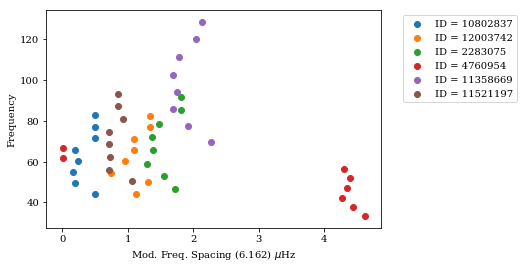

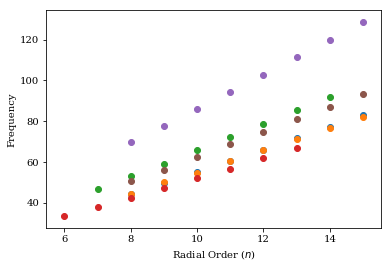

In [4]:
plt.figure(1)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))

plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ('+ str(u"%.3f" % dnu_avg) +') $\mu$Hz')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.savefig('seminar/manyrgbs.pdf')

plt.figure(2)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))
plt.xlabel('Radial Order ($n$)')
plt.ylabel('Frequency')
plt.show()

With all our required data, we can parse the data into a stan model constructed to perform a hierarchical Bayesian model. Hyperpriors have been introduced on a number of parameters based on values in the Vrard (2014) paper.

The model follows the form:
\begin{equation}
    \left(n + \epsilon + \frac{\alpha}{2}\left(n-n_{max}\right)^2 + \frac{\mathcal{AG}}{2\pi}\sin\left(\frac{2\pi(n-n_{max})}{\mathcal{G}} + \phi \right)\right) e^{\frac{n}{\tau}}
\end{equation}
where
\begin{equation}
    n_{max} = \frac{\nu_{max}}{\Delta\nu} - \epsilon
\end{equation}


$$ A = A_0 e^{-n_{max}/\tau} \longrightarrow A_0 = A_{n_{max}} e^{n_{max}/\tau}$$

In [21]:
code = '''
functions {
    real glitch(real n, real dnu, real numax, real epsilon, real alpha, real A, real G, real phi, real tau){
        real nmax = numax/dnu - epsilon;
        return (n + epsilon + alpha/2 * (n-nmax)^2 + 
                A*G/(2*pi()) * sin((2*pi()*(n-nmax))/G + phi)) * dnu * exp(-n/tau);
    }
}
data {
    int N;  //number of stars
    int M; //number of modes
    real n[N, M];
    real freq[N, M];
    real freq_err[N, M];
    real numax_obs[N];
    real numax_err[N];
    real dnu_guess[N];
}
parameters {
    real dnu[N];
    real numax[N];
    real<lower = -2.0*pi(), upper = 2.0*pi()> phi[N];
    //real<lower = 0> A[N];
    real<lower = 0> Anmax[N];
    real G[N];
    real<lower = 0> tau[N];
    
    // Hierarchical Parameters
    real epsilon_std[N];
    real<lower=0> eps_std;
    real epsA;
    real epsB;
    real alpha_std[N];
    real<lower=0> al_std;
    real alA;
    real alB;
    //real A_std[N];
    //real<lower=0> A_err;
    //real AA;
    //real AB;
    //real G_std[N];
    //real<lower=0> G_err;
    //real GA;
    
}

transformed parameters {
    real epsilon[N];
    real alpha[N];
    //real A[N];
    //real G[N];
    real A0[N];
    
    for (i in 1:N){
        epsilon[i] = epsilon_std[i] * eps_std + (epsA + epsB * log(dnu[i]));
        alpha[i] = alpha_std[i] * al_std + (alA * (dnu[i])^(-alB));
        //A[i] = A_std[i] * A_err + (AA * (dnu[i])^(-AB));
        //G[i] = G_std[i] * G_err + GA;
        A0[i] = Anmax[N] * exp((numax[i]/dnu[i] - epsilon[i])/tau[i]);
    }
}

model {
    real mod[M];
    for (i in 1:N){
        for (j in 1:M){
            mod[j] = glitch(n[i,j], dnu[i], numax[i], epsilon[i], alpha[i], A0[i], G[i], phi[i], tau[i]);
            // mod[j] ~ normal(freq[i], freq_err[i]);
        }
        freq[i,:] ~ normal(mod, freq_err[i,:]);
        dnu[i] ~ normal(dnu_guess[i], dnu_guess[i]*0.001);
        A0[i] ~ lognormal(log(0.06*dnu[i]^(-0.88)), 0.4);
    }
    
    //epsilon ~ uniform(-1.0, 2.0);
    //nmax ~ normal(10, 4);
    //alpha ~ lognormal(log(0.015*dnu^(-0.32)), 0.3);
    
    G ~ normal(3.08, 0.65);
    
    numax ~ normal(numax_obs, numax_err);
    
    tau ~ normal(50, 10);
    
    // Hierarchical Hyperpriors
    epsilon_std ~ normal(0, 1);
    eps_std ~ normal(0, 0.5);
    epsA ~ normal(0.601, 0.25);
    epsB ~ normal(0.632, 0.25);
    alpha_std ~ normal(0, 1);
    al_std ~ normal(0, 0.5);    
    alA ~ normal(0.015, 0.005);
    alB ~ normal(0.32, 0.08);
    //A_std ~ normal(0, 1);
    //A_err ~ normal(0, 0.5);
    //AA ~ normal(0.06, 0.02);
    //AB ~ normal(0.88, 0.05);
    //G_std ~ normal(0, 1);
    //G_err ~ normal(0.65, 0.5);
    //GA ~ normal(3.08, 0.1);
}
'''
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c983566ef395cbc24a80c9450cf4f2ad NOW.


In [22]:
stan_data = {'N': len(IDs),
         'M': maxmodes,
         'n': arr_n, 
         'freq': arr_freq,
         'freq_err': arr_freqerr,
         'numax_obs': Numax,
         'numax_err': Numax_err,
         'dnu_guess': dnu_avgarr
        }
start = {'dnu': dnu_avgarr,
         'numax': Numax,
         'eps_std': 0.01,
         'al_std': 0.01,
         'A_err': 0.01,
         #'G_err': 0.65,
         #'epsilon': epsilon,
         #'alpha': alpha,
         #'A': A,
         'G': G,
         'phi': phi,
         'epsA': 0.601,
         'epsB': 0.632,
         'alA': 0.015,
         'alB': 0.32,
         #'AA': 0.06,
         #'AB': 0.88,
         #'GA': 3.08
         'tau': tau
    }
nchains = 4

fit = sm.sampling(data=stan_data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

In [23]:
print(fit)

Inference for Stan model: anon_model_c983566ef395cbc24a80c9450cf4f2ad.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu[1]           5.48  3.2e-3 6.0e-3   5.47   5.48   5.48   5.48   5.49      4   1.91
dnu[2]            5.4  1.9e-3 5.1e-3   5.39   5.39    5.4    5.4   5.41      7   1.88
dnu[3]           6.43  2.0e-3 6.2e-3   6.42   6.42   6.43   6.43   6.44      9   1.41
dnu[4]           4.76  9.2e-4 3.6e-3   4.75   4.75   4.76   4.76   4.76     16   1.23
dnu[5]           8.43  4.9e-3 9.7e-3   8.41   8.42   8.43   8.43   8.44      4   2.07
dnu[6]           6.16  2.7e-3 7.5e-3   6.15   6.16   6.16   6.17   6.17      7   2.13
numax[1]        57.78    0.58   0.86  56.81  56.93  57.61  58.57  59.48      2   4.66
numax[2]        56.48    0.11   0.22  56.03  56.31  56.54  56.64  56.82      4   1.62
numax[3]        68.41     0.1   0.18

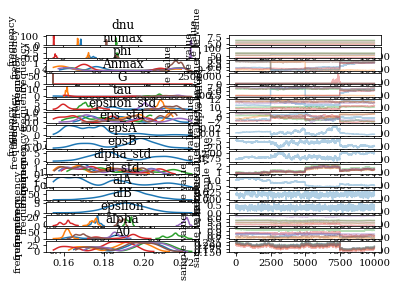

In [24]:
fit.plot()
plt.show()

[ 8.  9. 10. 11. 12. 13. 14. 15.]
[5.47969226 5.39616576 6.42715944 4.75508422 8.42514882 6.16227766]
[5.483661167259889, 5.391717113012496, 6.425904630453945, 4.7540210409470065, 8.425621833114374, 6.1615878856256625]
[57.78178086 56.48389488 68.40849816 43.14166706 98.26093121 67.99499347]
[5.48078038 5.45794865 5.77045268 5.21342684 6.27503286 5.70569974]
[0.78560277 0.72131705 0.92923505 0.83063518 0.81689056 0.75067544]
[0.19319963 0.18865547 0.19867806 0.1811314  0.19743214 0.1927431 ]
[3.92617782 2.42951125 6.18375981 3.07531006 6.88665082 6.56557521]
[-0.39118157 -1.14730242  0.72442812 -0.42636088  0.63703619  3.52469276]


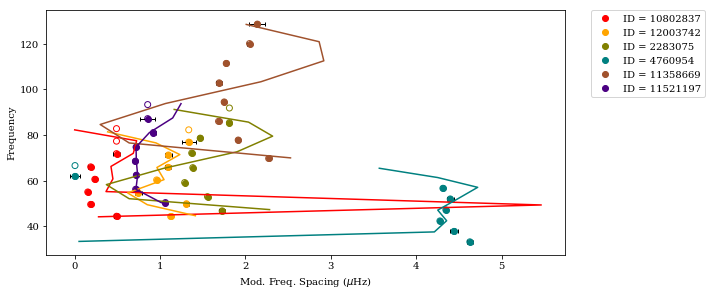

In [25]:
#%matplotlib inline
def model(n,dnu,numax,eps,alpha,A,G,phi,tau):
    nmax = numax/dnu - eps
    s = (n + eps + ((alpha/2)*(nmax-n)**2) + (((A*G)/(2*np.pi)) * np.sin((2*np.pi*(n-nmax))/G + phi)))*dnu*np.exp(-n/(tau))
    return s


fig = plt.figure(1, figsize=(12,4))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.6,0.85])

import itertools
colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo'))
    
for i in np.arange(0,len(IDs),1):
    # Iterate point colour
    colour = next(colours)
    # Plot all frequencies, and errorbars for the 'true' data
    ax.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    ax.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    ax.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)      
    
    # Plot the modelled fit
    g2 = model(arr_n[i],
           np.mean(fit['dnu'], axis=0)[i],
           np.mean(fit['numax'], axis=0)[i],
           np.mean(fit['epsilon'], axis=0)[i],
           np.mean(fit['alpha'], axis=0)[i],
           np.mean(fit['A0'], axis=0)[i],
           np.mean(fit['G'], axis=0)[i],
           np.mean(fit['phi'], axis=0)[i],
           np.mean(fit['tau'], axis=0)[i]
              )
    
    ax.plot(g2 % np.mean(fit['dnu'], axis=0)[i], g2,
             c=colour)
'''    
g1 = model(arr_n[0],
           np.mean(fit['dnu'], axis=0)[0],
           np.mean(fit['nmax'], axis=0)[0],
           np.mean(fit['epsilon'], axis=0)[0],
           np.mean(fit['alpha'], axis=0)[0],
           np.mean(fit['A'], axis=0)[0],
           np.mean(fit['G'], axis=0)[0],
           np.mean(fit['phi'], axis=0)[0],
           np.mean(fit['tau'], axis=0)[0])
    
plt.plot(g1 % np.mean(fit['dnu'], axis=0)[0], g1,
             label='Fit_2D')
 
'''       

print(arr_n[0])
print(np.mean(fit['dnu'], axis=0))
print(dnu_avgID)
print(np.mean(fit['numax'], axis=0))
print(np.mean(fit['epsilon'], axis=0))
print(np.mean(fit['alpha'], axis=0))
print(np.mean(fit['A0'], axis=0))
print(np.mean(fit['G'], axis=0))
print(np.mean(fit['phi'], axis=0))
#print(np.mean(fit['tau'], axis=0))


plt.legend()
plt.ylabel('Frequency')
plt.xlabel(r'Mod. Freq. Spacing ($\mu$Hz)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig('seminar/somergbseizure.pdf', bbox='tight_layout')

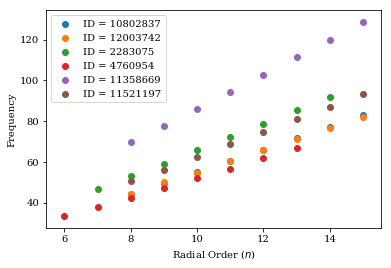

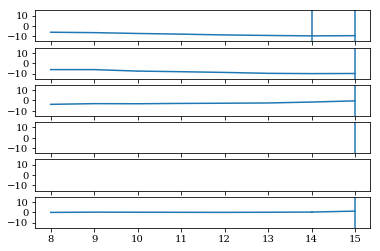

In [10]:
%matplotlib inline
plt.figure(2)
for i in np.arange(0,len(IDs),1):
    plt.scatter(modesID[i]['n'], modesID[i]['f0'], label=r'ID = '+str(IDs[i]))
plt.xlabel('Radial Order ($n$)')
plt.ylabel('Frequency')
plt.legend()
plt.show()


fig, ax = plt.subplots(len(IDs))
for i in np.arange(0,len(IDs),1):
    ax[i].errorbar(modesID[i]['n'], modesID[i]['f0'] - g2, yerr=modesID[i]['f0_err']*10)
    #ax[i].set_xlim([6,20])
    #ax[i].set_ylim([-3.5, 3.5])
    ax[i].set_ylim([-15, 15])
    
plt.show()

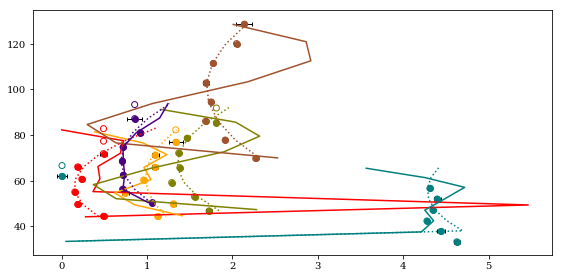

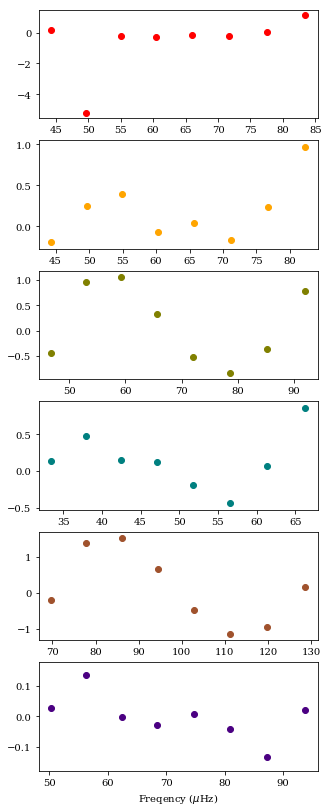

In [28]:
no_osc = np.loadtxt('/home/daniel/Documents/y4project/Dan_notebooks/no_osc_models.csv', delimiter=',')

fig = plt.figure(1, figsize=(12,4))
ax  = fig.add_subplot(111)
ax.set_position([0.1,0.1,0.6,0.85])

import itertools
colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo'))

osc = []
for i in np.arange(0,len(IDs),1):
    colour = next(colours)
    ax.scatter(modesID[i]['f0'] % dnu_avgID[i], modesID[i]['f0'],
                label='', zorder=-1, facecolors='none', edgecolors=colour)
    pts = modesID[i].loc[(modesID[i]['f0_err'] < 10e3)]
    ax.scatter(pts['f0'] % dnu_avgID[i], pts['f0'],
                label=r'ID = '+str(IDs[i]), c=colour)
    ax.errorbar(pts['f0'] % dnu_avgID[i], pts['f0'], xerr=pts['f0_err'],
                        zorder=0, fmt="none", label='', c='k',
                        capsize=2, markersize=4, elinewidth=1)      
    
    # Plot the modelled fit
    g2 = model(arr_n[i],
           np.mean(fit['dnu'], axis=0)[i],
           np.mean(fit['numax'], axis=0)[i],
           np.mean(fit['epsilon'], axis=0)[i],
           np.mean(fit['alpha'], axis=0)[i],
           np.mean(fit['A0'], axis=0)[i],
           np.mean(fit['G'], axis=0)[i],
           np.mean(fit['phi'], axis=0)[i],
           np.mean(fit['tau'], axis=0)[i]
              )
    ax.plot(g2 % np.mean(fit['dnu'], axis=0)[i], g2,
             c=colour)
    ax.plot(no_osc[i] % dnu_avgID[i], no_osc[i], linestyle=':', c=colour)
    osc.append(g2)

colours = itertools.cycle(('r', 'orange', 'olive', 'teal', 'sienna', 'indigo'))
fig, ax = plt.subplots(len(IDs), figsize=(5,14))
for i in np.arange(0,len(IDs),1):
    #ax[i].scatter(no_osc[i], (no_osc[i] % dnu_avgID[i]))
    #ax[i].scatter(osc[i], (osc[i] % dnu_avgID[i]))
    ax[i].scatter(no_osc[i], (no_osc[i] % dnu_avgID[i])-(osc[i] % np.mean(fit['dnu'], axis=0)[i]), c=next(colours))
plt.xlabel(r'Freqency ($\mu$Hz)')
plt.show()